In [2]:
import pandas as pd
import os
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings("ignore")

work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ/data'
os.chdir(work_dir)

selected_state = 'CA'
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

In [3]:
demand_scaling = 0.1 # only 10% of BEAM demand is used

bildaq_od_data = read_csv('Output/' + selected_state+ '/OD_summary_with_routed_distance.csv')
beam_od_data = read_csv('Validation/trips.csv')
beam_person_data = read_csv('Validation/final_persons.csv')
beam_household_data = read_csv('Validation/final_households.csv')
print(bildaq_od_data.columns)
print(beam_od_data.columns)
print(beam_person_data.columns)
print(beam_household_data.columns)

Index(['home_GEOID', 'home_geotype', 'home_microtype', 'populationGroupType',
       'destination', 'dest_geotype', 'dest_microtype', 'GC_distance',
       'distance', 'TripGeneration', 'OD'],
      dtype='object')
Index(['Unnamed: 0', 'person_id', 'legDepartureTime', 'PlanElementIndex',
       'startBlockGroup', 'endBlockGroup'],
      dtype='object')
Index(['person_id', 'earning', 'worker', 'student', 'hispanic.1', 'person_sex',
       'PNUM', 'sex', 'household_id', 'hours', 'MAR', 'person_age', 'edu',
       'school_zone_id', 'race_id', 'race', 'work_at_home', 'age',
       'work_zone_id', 'p_hispanic', 'relate', 'hispanic', 'TAZ', 'ptype',
       'pemploy', 'pstudent', 'home_x', 'home_y', 'age_16_to_19', 'age_16_p',
       'adult', 'male', 'female', 'has_non_worker', 'has_retiree',
       'has_preschool_kid', 'has_driving_kid', 'has_school_kid',
       'has_full_time', 'has_part_time', 'has_university',
       'student_is_employed', 'nonstudent_to_school', 'is_student',
       'is_

In [4]:
bildaq_od_data.loc[:, 'VMT'] = bildaq_od_data.loc[:, 'TripGeneration'] * bildaq_od_data.loc[:, 'distance']
print(bildaq_od_data.loc[:, 'VMT'].sum())

817557020.9322493


In [5]:
# assign census tract id to beam data
beam_od_data.loc[:, 'o_GEOID'] = beam_od_data.loc[:, 'startBlockGroup'] / 10
beam_od_data.loc[:, 'd_GEOID'] = beam_od_data.loc[:, 'endBlockGroup'] / 10

beam_od_data = beam_od_data.dropna()
beam_od_data.loc[:, ['o_GEOID', 'd_GEOID']] = beam_od_data.loc[:, ['o_GEOID', 'd_GEOID']].astype(int)
print(len(beam_od_data))
beam_od_data.head(5)                                                            


2529561


,Unnamed: 0,person_id,legDepartureTime,PlanElementIndex,startBlockGroup,endBlockGroup,o_GEOID,d_GEOID
0,1,1.0,8.066,2,6.085504e+10,6.085504e+10,6085503509,6085504202
1,3,1.0,8.235,4,6.085504e+10,6.085504e+10,6085504202,6085504202
2,5,1.0,14.670,6,6.085504e+10,6.085504e+10,6085504202,6085503509
3,8,2.0,6.909,2,6.085504e+10,6.085504e+10,6085503509,6085503509
4,10,2.0,12.926,4,6.085504e+10,6.085512e+10,6085503509,6085512308


In [6]:
#allocate home location for each person
beam_person_data = beam_person_data[['person_id', 'household_id']]
print(len(beam_person_data))
beam_household_data = beam_household_data[['household_id', 'block_id']]
beam_person_with_blockid = pd.merge(beam_person_data, beam_household_data,
                                    on = 'household_id', how = 'left')

print(len(beam_person_with_blockid))
beam_person_with_blockid.head(5)

717511
717511


,person_id,household_id,block_id
0,57953,2584691,60971530013001
1,57954,2584691,60971530013001
2,57955,2584691,60971530013001
3,57956,2584691,60971530013001
4,57957,2584691,60971530013001


In [7]:
beam_od_data[['person_id', 'startBlockGroup', 'endBlockGroup']] = \
beam_od_data[['person_id', 'startBlockGroup', 'endBlockGroup']].astype(int)
beam_od_data_with_home = pd.merge(beam_od_data, beam_person_with_blockid,
                                  on = 'person_id', how = 'left')
beam_od_data_with_home.head(5)

,Unnamed: 0,person_id,legDepartureTime,PlanElementIndex,startBlockGroup,endBlockGroup,o_GEOID,d_GEOID,household_id,block_id
0,1,1,8.066,2,60855035091,60855042022,6085503509,6085504202,1735309,60855035091006
1,3,1,8.235,4,60855042022,60855042022,6085504202,6085504202,1735309,60855035091006
2,5,1,14.670,6,60855042022,60855035091,6085504202,6085503509,1735309,60855035091006
3,8,2,6.909,2,60855035091,60855035091,6085503509,6085503509,1735309,60855035091006
4,10,2,12.926,4,60855035091,60855123082,6085503509,6085512308,1735309,60855035091006


In [8]:
beam_od_data_with_home.loc[:, 'home_bg'] = beam_od_data_with_home.loc[:, 'block_id'] / 1000
beam_od_data_with_home.loc[:, 'home_bg'] = beam_od_data_with_home.loc[:, 'home_bg'].astype(int)
beam_od_data_with_home.loc[:, 'trip_type'] = 'non-home'
criteria1 = (beam_od_data_with_home.loc[:, 'home_bg'] == beam_od_data_with_home.loc[:, 'startBlockGroup'])
beam_od_data_with_home.loc[criteria1, 'trip_type'] = 'home_origin'
criteria2 = (beam_od_data_with_home.loc[:, 'home_bg'] == beam_od_data_with_home.loc[:, 'endBlockGroup'])
beam_od_data_with_home.loc[criteria2, 'trip_type'] = 'home_dest'
beam_od_data_with_home.head(5)

,Unnamed: 0,person_id,legDepartureTime,PlanElementIndex,startBlockGroup,endBlockGroup,o_GEOID,d_GEOID,household_id,block_id,home_bg,trip_type
0,1,1,8.066,2,60855035091,60855042022,6085503509,6085504202,1735309,60855035091006,60855035091,home_origin
1,3,1,8.235,4,60855042022,60855042022,6085504202,6085504202,1735309,60855035091006,60855035091,non-home
2,5,1,14.670,6,60855042022,60855035091,6085504202,6085503509,1735309,60855035091006,60855035091,home_dest
3,8,2,6.909,2,60855035091,60855035091,6085503509,6085503509,1735309,60855035091006,60855035091,home_dest
4,10,2,12.926,4,60855035091,60855123082,6085503509,6085512308,1735309,60855035091006,60855035091,home_origin


In [9]:
beam_od_data_home_based = beam_od_data_with_home.loc[beam_od_data_with_home['trip_type'] != 'non-home']
beam_od_data_home_based.loc[:, 'home_GEOID'] = beam_od_data_home_based.loc[:, 'o_GEOID']
beam_od_data_home_based.loc[:, 'destination'] = beam_od_data_home_based.loc[:, 'd_GEOID']

beam_od_data_home_based.loc[beam_od_data_home_based['trip_type'] == 'home_dest', 'home_GEOID'] = \
beam_od_data_home_based.loc[:, 'd_GEOID']
beam_od_data_home_based.loc[beam_od_data_home_based['trip_type'] == 'home_dest', 'destination'] = \
beam_od_data_home_based.loc[:, 'o_GEOID']
beam_od_data_home_based.head(5)

,Unnamed: 0,person_id,legDepartureTime,PlanElementIndex,startBlockGroup,endBlockGroup,o_GEOID,d_GEOID,household_id,block_id,home_bg,trip_type,home_GEOID,destination
0,1,1,8.066,2,60855035091,60855042022,6085503509,6085504202,1735309,60855035091006,60855035091,home_origin,6085503509,6085504202
2,5,1,14.670,6,60855042022,60855035091,6085504202,6085503509,1735309,60855035091006,60855035091,home_dest,6085503509,6085504202
3,8,2,6.909,2,60855035091,60855035091,6085503509,6085503509,1735309,60855035091006,60855035091,home_dest,6085503509,6085503509
4,10,2,12.926,4,60855035091,60855123082,6085503509,6085512308,1735309,60855035091006,60855035091,home_origin,6085503509,6085512308
7,16,2,22.896,10,60855033041,60855035091,6085503304,6085503509,1735309,60855035091006,60855035091,home_dest,6085503509,6085503304


In [10]:
beam_home_based_od_agg = \
beam_od_data_home_based.groupby(['home_GEOID',	'destination'])[['person_id']].count()
beam_home_based_od_agg.columns = ['BEAM trips']
beam_home_based_od_agg = beam_home_based_od_agg.reset_index()

beam_home_based_od_agg.loc[:, 'BEAM trips'] /= demand_scaling
beam_home_based_od_agg.head(5)

,home_GEOID,destination,BEAM trips
0,6001400100,6001400100,1330.0
1,6001400100,6001400200,20.0
2,6001400100,6001400300,10.0
3,6001400100,6001400400,10.0
4,6001400100,6001400600,20.0


In [11]:
group_var = ['home_GEOID', 'home_geotype', 'home_microtype', 
       'destination', 'dest_geotype', 'dest_microtype', 'distance']
bildaq_od_data_agg = bildaq_od_data.groupby(group_var)[['TripGeneration']].sum()
bildaq_od_data_agg.columns = ['BILD-AQ trips']
bildaq_od_data_agg = bildaq_od_data_agg.reset_index()
bildaq_od_data_agg.head(5)

,home_GEOID,home_geotype,home_microtype,destination,dest_geotype,dest_microtype,distance,BILD-AQ trips
0,6001400100,A,5,6001400300,A,3.0,2.605883,194.590871
1,6001400100,A,5,6001400400,A,1.0,2.401490,10.472656
2,6001400100,A,5,6001400500,A,1.0,2.669223,13.231763
3,6001400100,A,5,6001400800,A,1.0,4.331786,2.287018
4,6001400100,A,5,6001400900,A,1.0,3.725306,0.890187


In [12]:
od_data_compare = pd.merge(bildaq_od_data_agg, beam_home_based_od_agg,
                           on = ['home_GEOID', 'destination'],
                           how = 'inner')
print(od_data_compare[['BILD-AQ trips', 'BEAM trips']].sum())
distance_bins = [0, 5, 10, 20, od_data_compare['distance'].max()]
distance_bin_labels = ['1-5', '5-10', '10-20', '>20']
od_data_compare.loc[:, 'distanceBin'] = pd.cut(od_data_compare.loc[:, 'distance'], distance_bins, 
                                                labels = distance_bin_labels, ordered = False)


BILD-AQ trips    1.040838e+07
BEAM trips       1.467372e+07
dtype: float64


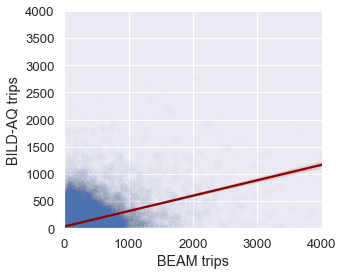

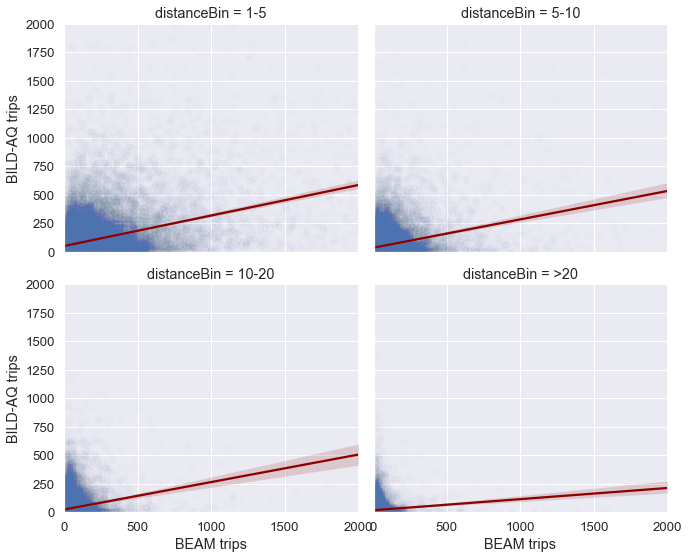

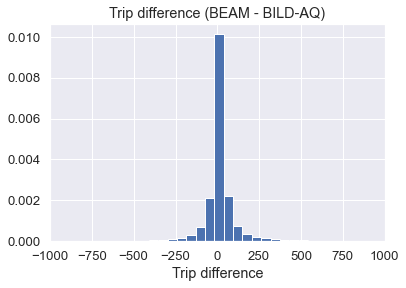

In [13]:
sns.lmplot(x = "BEAM trips", y = "BILD-AQ trips", data = od_data_compare,
          scatter_kws = {'alpha': 0.01}, line_kws = {'color': 'darkred'},
          height = 4, aspect =1.2)
plt.xlim([0,4000])
plt.ylim([0,4000])
plt.savefig('Plot/' + selected_state + '/validation_with_beam_by_OD.png', dpi = 200, bbox_inches = 'tight')
plt.show()

sns.lmplot(x = "BEAM trips", y = "BILD-AQ trips", data = od_data_compare,
          scatter_kws = {'alpha': 0.01}, line_kws = {'color': 'darkred'},
          col = "distanceBin", col_wrap = 2, height = 4, aspect =1.2)
plt.xlim([0,2000])
plt.ylim([0,2000])
plt.savefig('Plot/' + selected_state + '/validation_with_beam_by_OD_dist.png', dpi = 200, bbox_inches = 'tight')
plt.show()

od_data_compare.loc[:, 'difference'] = od_data_compare.loc[:, 'BEAM trips'] - \
od_data_compare.loc[:, 'BILD-AQ trips']

od_data_compare['difference'].hist(bins = 200, density = True)
plt.xlim([-1000, 1000])
plt.title('Trip difference (BEAM - BILD-AQ)')
plt.xlabel('Trip difference')
plt.savefig('Plot/' + selected_state + '/validation_with_beam_by_OD_diff.png', 
            dpi = 200, bbox_inches = 'tight')
plt.show()

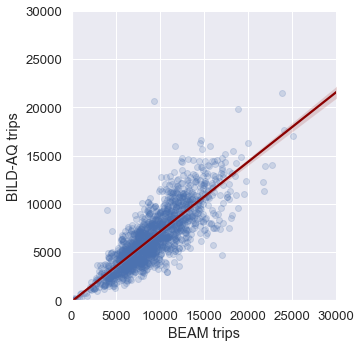

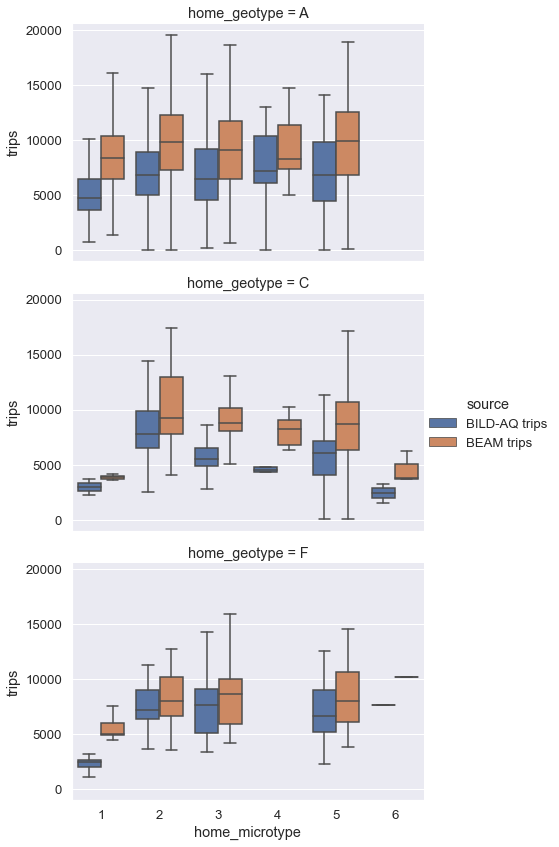

In [14]:
# compare trip production
od_origin_compare = \
od_data_compare.groupby(['home_GEOID', 'home_geotype', 'home_microtype'])[['BILD-AQ trips', 'BEAM trips']].sum()
od_origin_compare = od_origin_compare.reset_index()

sns.lmplot(x="BEAM trips", y="BILD-AQ trips", data = od_origin_compare,
          scatter_kws={'alpha': 0.2}, line_kws={'color': 'darkred'})
plt.xlim([0,30000])
plt.ylim([0,30000])
plt.savefig('Plot/' + selected_state + '/validation_with_beam_by_origin.png', dpi = 200, bbox_inches = 'tight')
plt.show()

od_origin_compare = pd.melt(od_origin_compare, id_vars = ['home_GEOID', 'home_geotype', 'home_microtype'],
                            value_vars = ['BILD-AQ trips',	'BEAM trips'],
                            var_name='source', value_name='trips')
od_origin_compare = od_origin_compare.reset_index()

sns.catplot(x = "home_microtype", y = "trips", hue = "source",
            data = od_origin_compare, row = "home_geotype",
            kind = "box", height = 4, aspect = 1.6, showfliers = False)
plt.savefig('Plot/' + selected_state + '/validation_with_beam_by_origin_micro_geotype.png', dpi = 200, bbox_inches = 'tight')
plt.show()

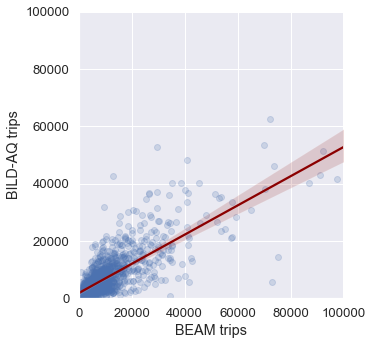

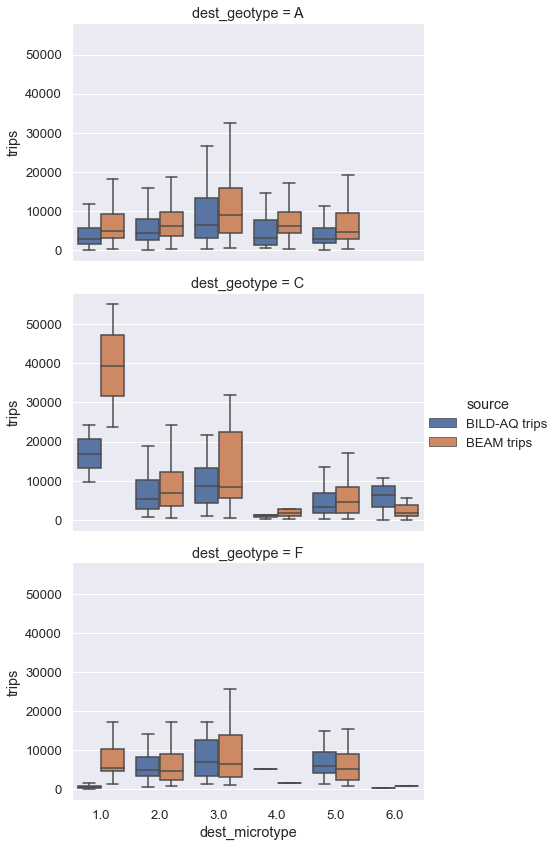

In [15]:
# compare trip attraction
od_origin_compare = \
od_data_compare.groupby(['destination', 'dest_geotype', 'dest_microtype'])[['BILD-AQ trips', 'BEAM trips']].sum()
od_origin_compare = od_origin_compare.reset_index()

sns.lmplot(x="BEAM trips", y="BILD-AQ trips", data = od_origin_compare,
          scatter_kws={'alpha': 0.2}, line_kws={'color': 'darkred'})
plt.xlim([0,100000])
plt.ylim([0,100000])
plt.savefig('Plot/' + selected_state + '/validation_with_beam_by_destination.png', dpi = 200, bbox_inches = 'tight')
plt.show()

od_origin_compare = pd.melt(od_origin_compare, id_vars = ['destination', 'dest_geotype', 'dest_microtype'],
                            value_vars = ['BILD-AQ trips',	'BEAM trips'],
                            var_name='source', value_name='trips')
od_origin_compare = od_origin_compare.reset_index()

sns.catplot(x = "dest_microtype", y = "trips", hue = "source",
            data = od_origin_compare, row = "dest_geotype",
            kind = "box", height = 4, aspect = 1.6, showfliers = False)
plt.savefig('Plot/' + selected_state + '/validation_with_beam_by_destination_micro_geotype.png', dpi = 200, bbox_inches = 'tight')
plt.show()